<a href="https://colab.research.google.com/github/2bahaa/Elevvo-pathways-Tasks/blob/main/Traffic_Sign_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import time
import pathlib
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

In [2]:
# --- Step 0: Setup GPU and environment ---
!nvidia-smi  # should show T4

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

Fri Aug 15 16:47:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!unzip /content/GTSRB.zip -d /content/GTSRB_data


In [24]:
from pathlib import Path

DATA_DIR = Path('/content/GTSRB_data')
TRAIN_DIR = DATA_DIR / 'Train'
TEST_DIR = DATA_DIR / 'Test'
META_DIR = DATA_DIR / 'Meta'

IMG_SIZE = (224, 224)           # small size to speed up experiments; you may increase to 96/128
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
NUM_EPOCHS = 8
NUM_CLASSES = None  # will be inferred

print('DATA_DIR exists:', DATA_DIR.exists())

DATA_DIR exists: True


In [25]:
# ====================================================
# Helper: plot history
# ====================================================
def plot_history(history, title='Training'):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history.get('val_loss', []), label='val_loss')
    plt.legend(); plt.title(title+' - Loss')
    plt.subplot(1,2,2)
    plt.plot(history.history.get('accuracy', history.history.get('acc')), label='train_acc')
    plt.plot(history.history.get('val_accuracy', []), label='val_acc')
    plt.legend(); plt.title(title+' - Accuracy')
    plt.show()

# ====================================================
# Load datasets (no caching to avoid RAM crash)
# ====================================================
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)
print('Detected classes:', NUM_CLASSES)

# Prefetch (no .cache())
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

# ====================================================
# Data augmentation
# ====================================================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomTranslation(0.06, 0.06),
    layers.RandomContrast(0.08),
], name='data_augmentation')


Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.
Detected classes: 43


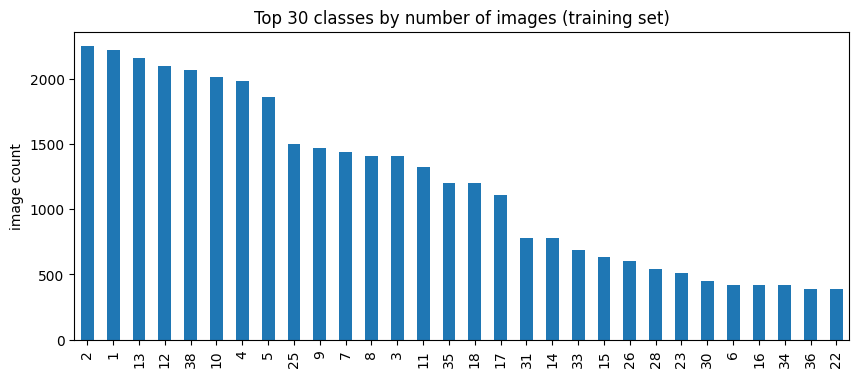

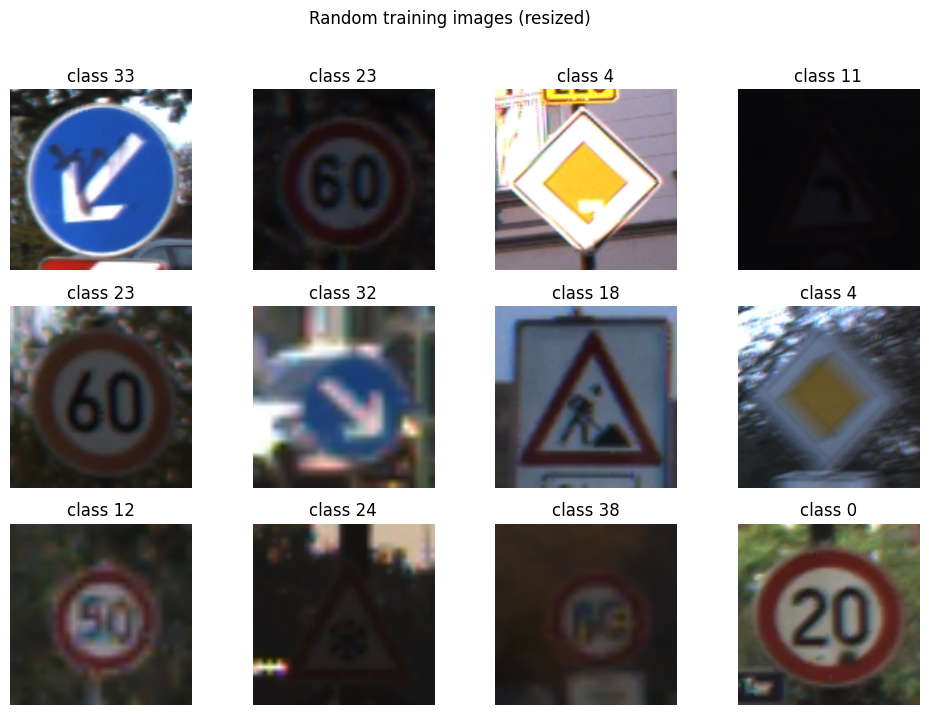

Min images per class: 210
Max images per class: 2250
Median images per class: 600.0


In [26]:
# %% Cell 4 - Dataset visualization & insights
"""
Plot samples, class distribution and a few image examples.
"""

# Class distribution (count images per class by walking folders)
counts = {}
for class_name in CLASS_NAMES:
    class_dir = TRAIN_DIR / class_name
    counts[class_name] = sum(1 for _ in class_dir.glob('*') if _.is_file())

counts_series = pd.Series(counts).sort_values(ascending=False)
plt.figure(figsize=(10,4))
counts_series.head(30).plot(kind='bar')
plt.title('Top 30 classes by number of images (training set)')
plt.ylabel('image count')
plt.show()

# show random samples
plt.figure(figsize=(12,8))
for images, labels in train_ds.take(1):
    images = images.numpy().astype('uint8')
    labels = labels.numpy()
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i])
        plt.title(f'class {labels[i]}')
        plt.axis('off')
plt.suptitle('Random training images (resized)')
plt.show()

# simple insight: class imbalance check
print('Min images per class:', counts_series.min())
print('Max images per class:', counts_series.max())
print('Median images per class:', counts_series.median())

In [27]:
# %% Cell 7 - Build Custom CNN (efficient)
"""
A compact and efficient custom CNN for traffic sign recognition.
Uses Depthwise Separable Convolutions for speed, small filter counts to reduce parameters,
and Global Average Pooling for better generalization.
"""

def make_custom_cnn(input_shape=(*IMG_SIZE, 3), num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    # Block 1
    x = layers.SeparableConv2D(16, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # Block 2
    x = layers.SeparableConv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # Block 3
    x = layers.SeparableConv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # Global Pooling instead of Flatten (fewer params)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # Dense Layer
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    model = keras.Model(inputs, outputs, name='custom_cnn_efficient')
    return model

custom_model = make_custom_cnn()
custom_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
custom_model.summary()


Model: "custom_cnn_efficient"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_9              │ (None, 224, 224, 16)   │            91 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_10             │ (None, 112, 112, 32)   │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_11             │ (None, 56, 56, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,838 (42.34 KB)

 Trainable params: 10,486 (40.96 KB)

 Non-trainable params: 352 (1.38 KB)

Epoch 1/8
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.0385 - loss: 4.2052

491/491 ━━━━━━━━━━━━━━━━━━━━ 448s 879ms/step - accuracy: 0.0385 - loss: 4.2049 - val_accuracy: 0.0575 - val_loss: 3.8048 - learning_rate: 1.0000e-04
Epoch 2/8
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.0804 - loss: 3.7427

491/491 ━━━━━━━━━━━━━━━━━━━━ 427s 868ms/step - accuracy: 0.0804 - loss: 3.7425 - val_accuracy: 0.1472 - val_loss: 3.2898 - learning_rate: 1.0000e-04
Epoch 3/8
491/491 ━━━━━━━━━━━━━━━━━━━━ 433s 851ms/step - accuracy: 0.1098 - loss: 3.5467 - val_accuracy: 0.1320 - val_loss: 3.2327 - learning_rate: 1.0000e-04
Epoch 4/8
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.1095 - loss: 3.4315

491/491 ━━━━━━━━━━━━━━━━━━━━ 438s 843ms/step - accuracy: 0.1095 - loss: 3.4313 - val_accuracy: 0.1520 - val_loss: 3.1158 - learning_rate: 1.0000e-04
Epoch 5/8
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.1230 - loss: 3.3219

491/491 ━━━━━━━━━━━━━━━━━━━━ 418s 850ms/step - accuracy: 0.1230 - loss: 3.3218 - val_accuracy: 0.1624 - val_loss: 3.0362 - learning_rate: 1.0000e-04
Epoch 6/8
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.1313 - loss: 3.2310

491/491 ━━━━━━━━━━━━━━━━━━━━ 443s 854ms/step - accuracy: 0.1313 - loss: 3.2309 - val_accuracy: 0.1757 - val_loss: 2.9755 - learning_rate: 1.0000e-04
Epoch 7/8
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.1420 - loss: 3.1545

491/491 ━━━━━━━━━━━━━━━━━━━━ 436s 842ms/step - accuracy: 0.1420 - loss: 3.1544 - val_accuracy: 0.1844 - val_loss: 2.9140 - learning_rate: 1.0000e-04
Epoch 8/8
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.1580 - loss: 3.0791

491/491 ━━━━━━━━━━━━━━━━━━━━ 437s 832ms/step - accuracy: 0.1580 - loss: 3.0791 - val_accuracy: 0.1917 - val_loss: 2.8762 - learning_rate: 1.0000e-04
Custom CNN training time (s): 3481.1


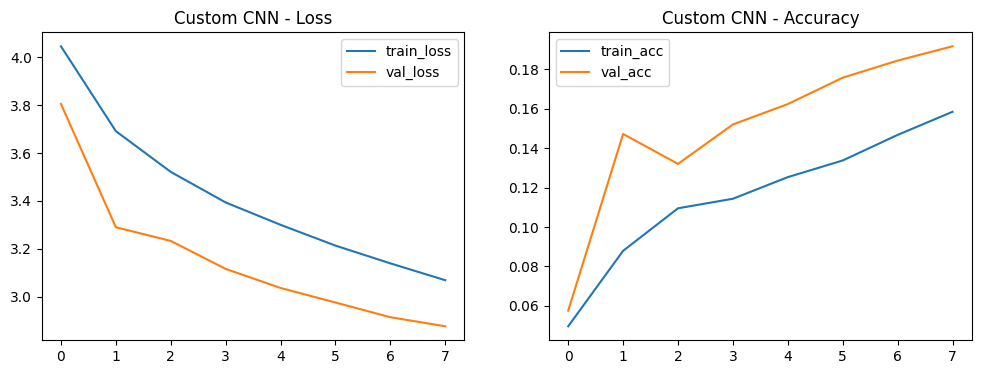

In [10]:
# %% Cell 8 - Train Custom CNN (with callbacks & timing)
"""
Train the custom CNN and measure wall-clock training time. Uses ModelCheckpoint, EarlyStopping.
"""

callbacks = [
    keras.callbacks.ModelCheckpoint('custom_cnn_best.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

start_time = time.time()
history_custom = custom_model.fit(
    train_ds_pref,
    validation_data=val_ds_pref,
    epochs=NUM_EPOCHS,
    callbacks=callbacks
)
custom_train_time = time.time() - start_time
print(f'Custom CNN training time (s): {custom_train_time:.1f}')

plot_history(history_custom, title='Custom CNN')


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━

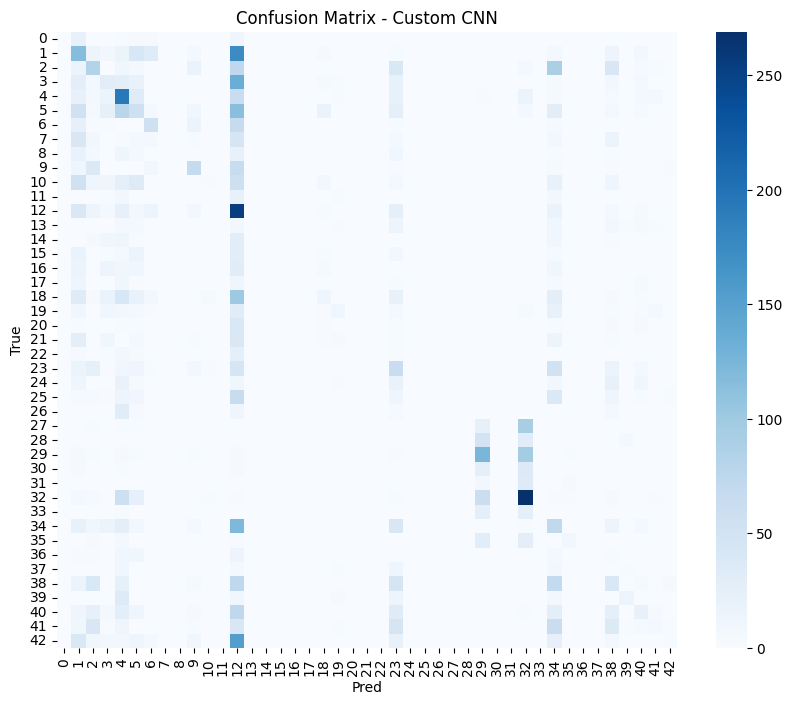

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.16      0.26      0.20       448
          10       0.22      0.22      0.22       390
          11       0.14      0.10      0.12       297
          12       0.24      0.49      0.32       396
          13       0.14      0.13      0.13       441
          14       0.38      0.32      0.35       173
          15       0.00      0.00      0.00       146
          16       0.00      0.00      0.00        82
          17       0.39      0.33      0.36       206
          18       0.10      0.01      0.01       248
          19       0.00      0.00      0.00        46
           2       0.12      0.59      0.20       429
          20       0.00      0.00      0.00        67
          21       0.00      0.00      0.00        75
          22       0.00      0.00      0.00        89
          23       0.00      0.00      0.00        98
          24       0.00    

In [11]:
# %% Cell 9 - Evaluate Custom CNN & Confusion Matrix
"""
Evaluate on validation set and plot confusion matrix and classification report.
"""

# load best weights just to be sure
custom_model.load_weights('custom_cnn_best.h5')

val_preds = []
val_labels = []
for x, y in val_ds_pref:
    preds = custom_model.predict(x)
    val_preds.append(np.argmax(preds, axis=1))
    val_labels.append(y.numpy())

val_preds = np.concatenate(val_preds)
val_labels = np.concatenate(val_labels)

acc = (val_preds == val_labels).mean()
print(f'Custom CNN validation accuracy: {acc:.4f}')

cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10,8))
# show a smaller subset if many classes
if NUM_CLASSES <= 30:
    sns.heatmap(cm, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, fmt='d', cmap='Blues')
    plt.xticks(rotation=90)
else:
    sns.heatmap(cm, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Custom CNN')
plt.ylabel('True'); plt.xlabel('Pred');
plt.show()

print(classification_report(val_labels, val_preds, target_names=[str(c) for c in CLASS_NAMES], zero_division=0))

In [28]:
# ====================================================
# MobileNetV2 model setup
# ====================================================
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE,3))
base_model.trainable = False  # Freeze base for first stage

inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Lambda(mobilenet_preprocess)(x)  # scale [-1,1]
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)

mobilenet_model = keras.Model(inputs, outputs, name='mobilenetv2_transfer')

mobilenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()


Model: "mobilenetv2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,597,995 (9.91 MB)

 Trainable params: 339,499 (1.30 MB)

 Non-trainable params: 2,258,496 (8.62 MB)


--- Training head ---
Epoch 1/8
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5937 - loss: 1.4311

981/981 ━━━━━━━━━━━━━━━━━━━━ 83s 73ms/step - accuracy: 0.5938 - loss: 1.4306 - val_accuracy: 0.8303 - val_loss: 0.5100 - learning_rate: 0.0010
Epoch 2/8
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7879 - loss: 0.6419

981/981 ━━━━━━━━━━━━━━━━━━━━ 75s 70ms/step - accuracy: 0.7879 - loss: 0.6419 - val_accuracy: 0.8732 - val_loss: 0.3931 - learning_rate: 0.0010
Epoch 3/8
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8078 - loss: 0.5653

981/981 ━━━━━━━━━━━━━━━━━━━━ 69s 71ms/step - accuracy: 0.8078 - loss: 0.5652 - val_accuracy: 0.8753 - val_loss: 0.3756 - learning_rate: 0.0010
Epoch 4/8
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8231 - loss: 0.5193

981/981 ━━━━━━━━━━━━━━━━━━━━ 82s 70ms/step - accuracy: 0.8231 - loss: 0.5193 - val_accuracy: 0.8887 - val_loss: 0.3338 - learning_rate: 0.0010
Epoch 5/8
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8275 - loss: 0.4938

981/981 ━━━━━━━━━━━━━━━━━━━━ 69s 70ms/step - accuracy: 0.8275 - loss: 0.4938 - val_accuracy: 0.8944 - val_loss: 0.3097 - learning_rate: 0.0010
Epoch 6/8
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8448 - loss: 0.4493

981/981 ━━━━━━━━━━━━━━━━━━━━ 92s 80ms/step - accuracy: 0.8448 - loss: 0.4493 - val_accuracy: 0.9061 - val_loss: 0.2734 - learning_rate: 0.0010
Epoch 7/8
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8484 - loss: 0.4410

981/981 ━━━━━━━━━━━━━━━━━━━━ 69s 70ms/step - accuracy: 0.8484 - loss: 0.4410 - val_accuracy: 0.9065 - val_loss: 0.2715 - learning_rate: 0.0010
Epoch 8/8
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8554 - loss: 0.4146

981/981 ━━━━━━━━━━━━━━━━━━━━ 92s 80ms/step - accuracy: 0.8554 - loss: 0.4146 - val_accuracy: 0.9125 - val_loss: 0.2697 - learning_rate: 0.0010
Head training time (s): 633.3


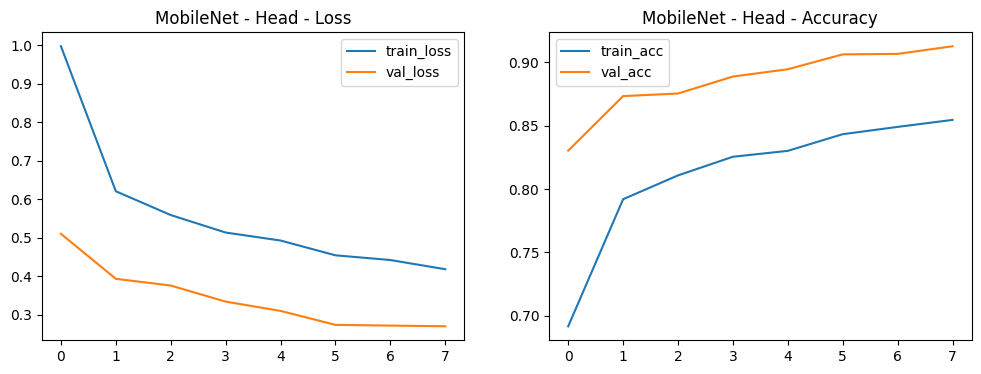


--- Fine-tuning last 30 layers ---
Epoch 1/8
981/981 ━━━━━━━━━━━━━━━━━━━━ 103s 93ms/step - accuracy: 0.6939 - loss: 1.0212 - val_accuracy: 0.9028 - val_loss: 0.2828 - learning_rate: 1.0000e-05
Epoch 2/8
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8243 - loss: 0.5245

981/981 ━━━━━━━━━━━━━━━━━━━━ 140s 91ms/step - accuracy: 0.8243 - loss: 0.5245 - val_accuracy: 0.9283 - val_loss: 0.2116 - learning_rate: 1.0000e-05
Epoch 3/8
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8670 - loss: 0.3943

981/981 ━━━━━━━━━━━━━━━━━━━━ 141s 90ms/step - accuracy: 0.8671 - loss: 0.3943 - val_accuracy: 0.9429 - val_loss: 0.1802 - learning_rate: 1.0000e-05
Epoch 4/8
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8910 - loss: 0.3232

981/981 ━━━━━━━━━━━━━━━━━━━━ 143s 92ms/step - accuracy: 0.8910 - loss: 0.3232 - val_accuracy: 0.9445 - val_loss: 0.1636 - learning_rate: 1.0000e-05
Epoch 5/8
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9118 - loss: 0.2662

981/981 ━━━━━━━━━━━━━━━━━━━━ 152s 102ms/step - accuracy: 0.9118 - loss: 0.2661 - val_accuracy: 0.9510 - val_loss: 0.1431 - learning_rate: 1.0000e-05
Epoch 6/8
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9230 - loss: 0.2252

981/981 ━━━━━━━━━━━━━━━━━━━━ 131s 91ms/step - accuracy: 0.9230 - loss: 0.2252 - val_accuracy: 0.9601 - val_loss: 0.1244 - learning_rate: 1.0000e-05
Epoch 7/8
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9323 - loss: 0.2026

981/981 ━━━━━━━━━━━━━━━━━━━━ 99s 101ms/step - accuracy: 0.9323 - loss: 0.2026 - val_accuracy: 0.9651 - val_loss: 0.1119 - learning_rate: 1.0000e-05
Epoch 8/8
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9441 - loss: 0.1756

981/981 ━━━━━━━━━━━━━━━━━━━━ 99s 101ms/step - accuracy: 0.9441 - loss: 0.1756 - val_accuracy: 0.9661 - val_loss: 0.1030 - learning_rate: 1.0000e-05


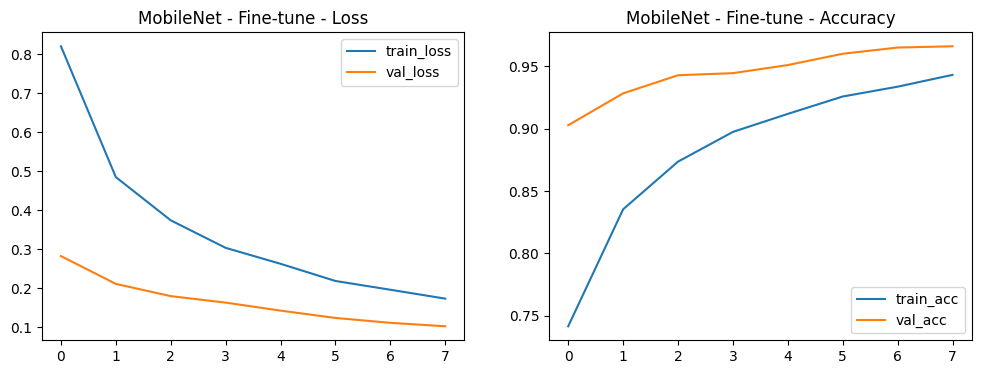

In [29]:
# ====================================================
# Stage 1: Train head
# ====================================================
callbacks_tf = [
    keras.callbacks.ModelCheckpoint('mobilenet_head_best.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

print("\n--- Training head ---")
start_time = time.time()
history_mobilenet = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=callbacks_tf
)
print(f'Head training time (s): {time.time() - start_time:.1f}')
plot_history(history_mobilenet, title='MobileNet - Head')

# ====================================================
# Stage 2: Fine-tuning last layers
# ====================================================
print("\n--- Fine-tuning last 30 layers ---")
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

mobilenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_mobilenet_ft = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=callbacks_tf
)
plot_history(history_mobilenet_ft, title='MobileNet - Fine-tune')

In [ ]:
# %% Cell 12 - Evaluate MobileNet & compare
"""
Evaluate MobileNet model on validation set and compare metrics and training times.
"""

mobilenet_model.load_weights('mobilenet_head_best.h5')  # load best of head training

# predict on validation
val_preds_m = []
val_labels_m = []
for x, y in val_ds:
    preds = mobilenet_model.predict(x)
    val_preds_m.append(np.argmax(preds, axis=1))
    val_labels_m.append(y.numpy())
val_preds_m = np.concatenate(val_preds_m)
val_labels_m = np.concatenate(val_labels_m)

acc_m = (val_preds_m == val_labels_m).mean()
print(f'MobileNet validation accuracy (head): {acc_m:.4f}')

cm_m = confusion_matrix(val_labels_m, val_preds_m)
plt.figure(figsize=(10,8))
if NUM_CLASSES <= 30:
    sns.heatmap(cm_m, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, fmt='d', cmap='Blues')
    plt.xticks(rotation=90)
else:
    sns.heatmap(cm_m, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - MobileNet (head)')
plt.ylabel('True'); plt.xlabel('Pred');
plt.show()

print(classification_report(val_labels_m, val_preds_m, target_names=[str(c) for c in CLASS_NAMES], zero_division=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
# %% Save final MobileNet model and provide inference utility
"""
Save the trained MobileNet model and provide a helper to run inference on images from TEST_DIR.
If your TEST_DIR contains only images (no labels), this will output predictions per filename.
"""

# Save MobileNet model
mobilenet_model.save('mobilenetv2_final')
print('MobileNet model saved to disk')

# inference helper for images in TEST_DIR
from tensorflow.keras.preprocessing import image
import pandas as pd
import numpy as np
from pathlib import Path

def predict_folder(model, folder, batch_size=64):
    """Predicts on all images in a folder and returns DataFrame with filename and predicted label."""
    folder = Path(folder)
    imgs = list(sorted([p for p in folder.glob('*') if p.suffix.lower() in ['.png', '.jpg', '.jpeg']]))
    filenames = [str(p.name) for p in imgs]
    results = []
    all_batches = []

    for p in imgs:
        img = image.load_img(p, target_size=IMG_SIZE)
        arr = image.img_to_array(img)
        arr = arr / 255.0
        all_batches.append(arr)

    if not all_batches:
        return pd.DataFrame()

    arr = np.stack(all_batches, axis=0)
    preds = model.predict(arr, batch_size=batch_size)
    pred_labels = np.argmax(preds, axis=1)

    df = pd.DataFrame({'filename': filenames, 'predicted_class': [CLASS_NAMES[i] for i in pred_labels]})
    return df

if TEST_DIR.exists():
    df_preds = predict_folder(mobilenet_model, TEST_DIR)
    print('Sample predictions (MobileNet model):')
    print(df_preds.head())
    df_preds.to_csv('test_predictions_mobilenet.csv', index=False)
    print('Predictions saved to test_predictions_mobilenet.csv')
else:
    print('TEST_DIR not found - skip inference')
